In [1]:
# Import necessary libraries
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path_marta = '/content/drive/MyDrive/Colab Notebooks/Master/2-cuatri/IA_rad/Final_Proyect/USSalivaryGlands/Imágenes + Labels'
image_path = base_path_marta
base_path_noelia = base_path_marta

In [3]:
Anonymized_data_df = pd.read_excel(base_path_noelia + '/Anonymized images_student.xlsx')
Anonymized_data_df['Anonymized ID'] = Anonymized_data_df['Anonymized ID'].astype(str).str.zfill(3)
Anonymized_data_df

,Center,Anonymized ID,Patient ID,parotid/submandibular,machine,OMERACT score,Sex,Age at US evaluation,disease duration
0,Udine (Italy),001,1,submandibular,samsung,3,F,72.0,18
1,Udine (Italy),002,1,parotid,samsung,3,F,72.0,18
2,Udine (Italy),003,2,parotid,samsung,3,F,59.0,1
3,Udine (Italy),004,3,parotid,samsung,0,F,65.0,8
4,Udine (Italy),005,3,submandibular,samsung,0,F,65.0,8
...,...,...,...,...,...,...,...,...,...
195,Belgrade (Serbia),214,100,parotid,GE,2,M,19.0,8
196,Belgrade (Serbia),215,101,submandibular,GE,2,F,42.0,4
197,Belgrade (Serbia),216,101,submandibular,GE,2,F,42.0,4
198,Belgrade (Serbia),217,101,parotid,GE,0,F,42.0,4


In [4]:
#JUST SPLIT PATIENT IDs
patient_groups = Anonymized_data_df.groupby('Patient ID')['Anonymized ID'].apply(list)


train_val_patients, test_patients = train_test_split(patient_groups, test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(train_val_patients, test_size=0.3, random_state=42)

#Lists to stor IDs
train_ids = [image_id for patient_ids in train_patients for image_id in patient_ids]
test_ids = [image_id for patient_ids in test_patients for image_id in patient_ids]
val_ids = [image_id for patient_ids in val_patients for image_id in patient_ids]

# Filter the original df
train_df = Anonymized_data_df[Anonymized_data_df['Anonymized ID'].isin(train_ids)]
test_df = Anonymized_data_df[Anonymized_data_df['Anonymized ID'].isin(test_ids)]
val_df = Anonymized_data_df[Anonymized_data_df['Anonymized ID'].isin(val_ids)]


# Get the image paths and labels for training and test subsets
train_labels = train_df['OMERACT score'].tolist()
test_labels = test_df['OMERACT score'].tolist()
val_labels = val_df['OMERACT score'].tolist()

# Images (path)

image_files = os.listdir(base_path_noelia)
image_files.remove('Anonymized images_student.xlsx')
image_files.remove('labels_students.csv')

# Get the image paths and labels for training and test subsets
train_image_paths = [os.path.join(base_path_noelia, str(image_id) + '.jpg') for image_id in train_df['Anonymized ID']]

test_image_paths = [os.path.join(base_path_noelia, str(image_id) + '.jpg') for image_id in test_df['Anonymized ID']]

val_image_paths = [os.path.join(base_path_noelia, str(image_id) + '.jpg') for image_id in val_df['Anonymized ID']]

# Preprocess

In [5]:
def crop_images(image_paths, target_width, target_height):
    cropped_images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get the dimensions of the original image
        height, width, _ = img_rgb.shape

        # Calculate the number of pixels to crop from each side to keep the center
        left_crop = (width - target_width) // 2
        right_crop = width - left_crop - target_width

        # Crop the image while keeping the top intact
        cropped_img = img_rgb[:, left_crop:left_crop + target_width]
        cropped_img = cropped_img[:target_height]
        cropped_images.append(cropped_img)

    return cropped_images


def normalize_images(cropped_images):
    normalized_images = []
    for img in cropped_images:
        # Normalize (0-1)
        img_float = img.astype(np.float32) / 255.0
        normalized_images.append(img_float)
    return normalized_images


def resize_images(images, new_size):
    resized_images = []
    for img in images:
      resized_img = cv2.resize(img, new_size)
      resized_images.append(resized_img)
    return resized_images



In [6]:
#Crop the images proportionally

target_width = 500
target_height = 300
new_size= [224,224]
# Crop images
cropped_train_images = crop_images(train_image_paths, target_width, target_height)
cropped_val_images = crop_images(val_image_paths, target_width, target_height)
cropped_test_images = crop_images(test_image_paths, target_width, target_height)

# Normalize images
normalized_train_images = normalize_images(cropped_train_images)
normalized_val_images = normalize_images(cropped_val_images)
normalized_test_images = normalize_images(cropped_test_images)

# Resize images
resized_train_images = resize_images(normalized_train_images, new_size)
resized_val_images = resize_images(normalized_val_images, new_size)
resized_test_images = resize_images(normalized_test_images, new_size)


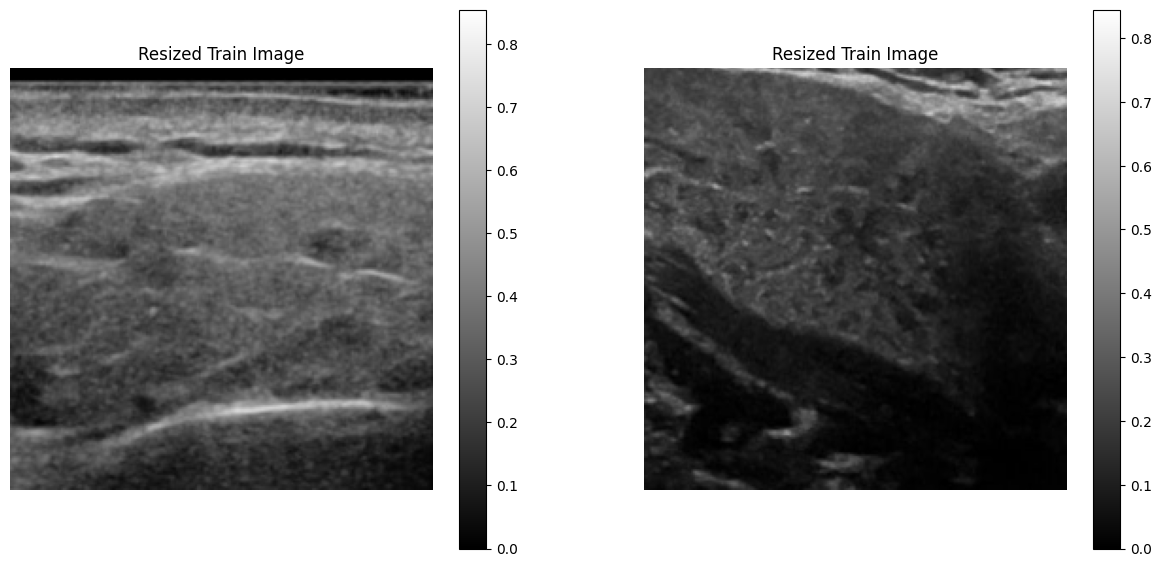

In [7]:
import random
import matplotlib.pyplot as plt

# Función para mostrar imágenes con la barra de color en escala de grises
def show_images_with_gray_colorbar(images, titles):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.colorbar()
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Seleccionar aleatoriamente dos imágenes del conjunto de entrenamiento después del redimensionamiento
random_resized_train_indices = random.sample(range(len(resized_train_images)), 2)
random_resized_train_images = [resized_train_images[i] for i in random_resized_train_indices]

# Mostrar imágenes aleatorias del conjunto de entrenamiento después del redimensionamiento con la barra de color en escala de grises
show_images_with_gray_colorbar(random_resized_train_images, ['Resized Train Image'] * 2)



In [8]:
# Convert to numpy
train_data = np.array(resized_train_images)
val_data = np.array(resized_val_images)
test_data = np.array(resized_test_images)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

#Check Shapes
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(115, 224, 224, 3)
(48, 224, 224, 3)
(37, 224, 224, 3)


# Augmentation:

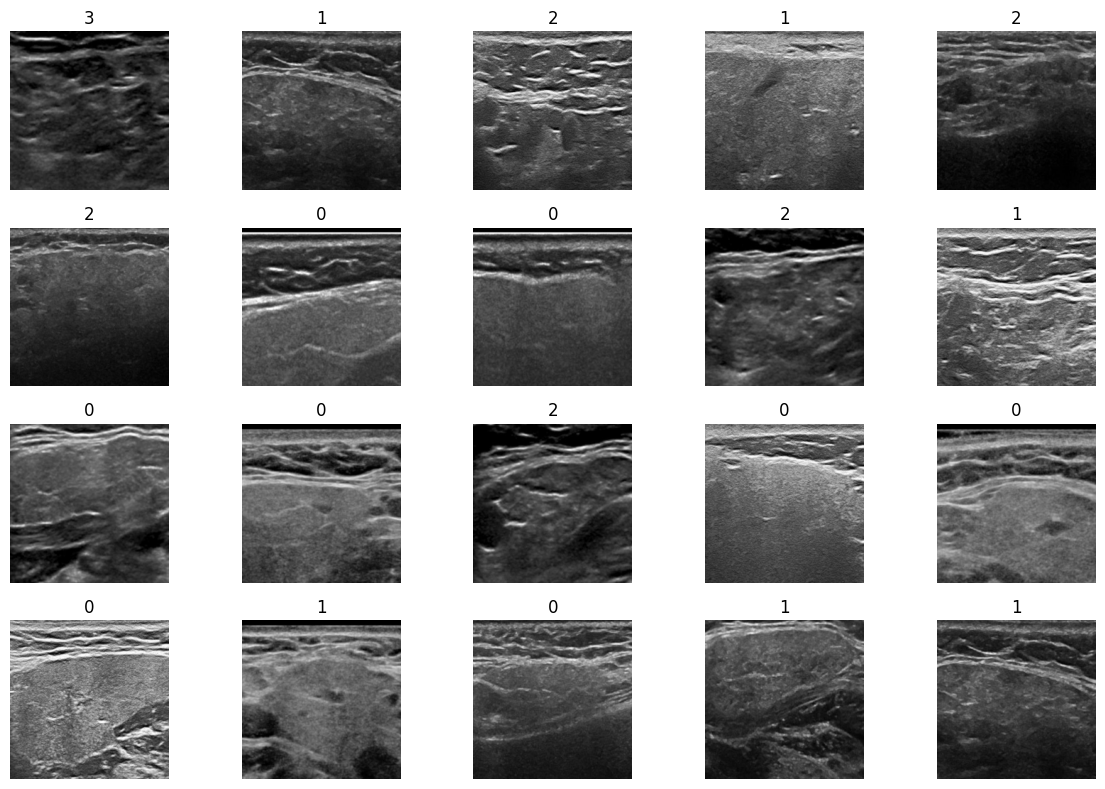

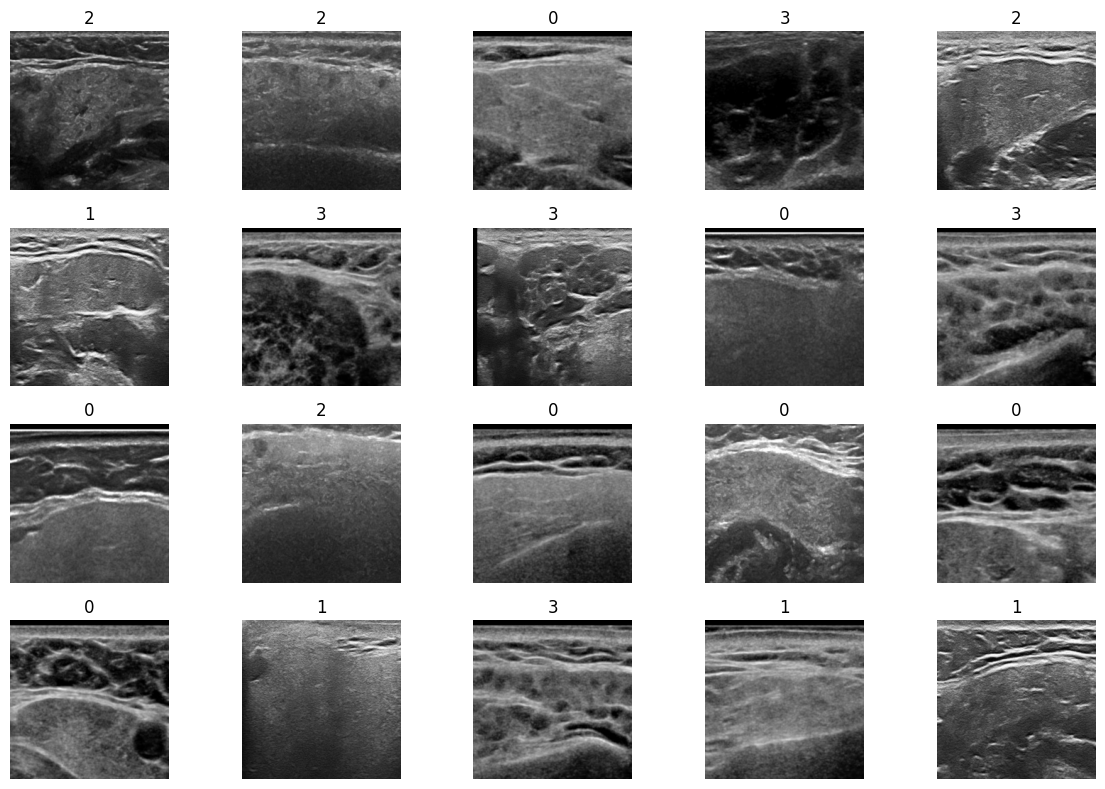

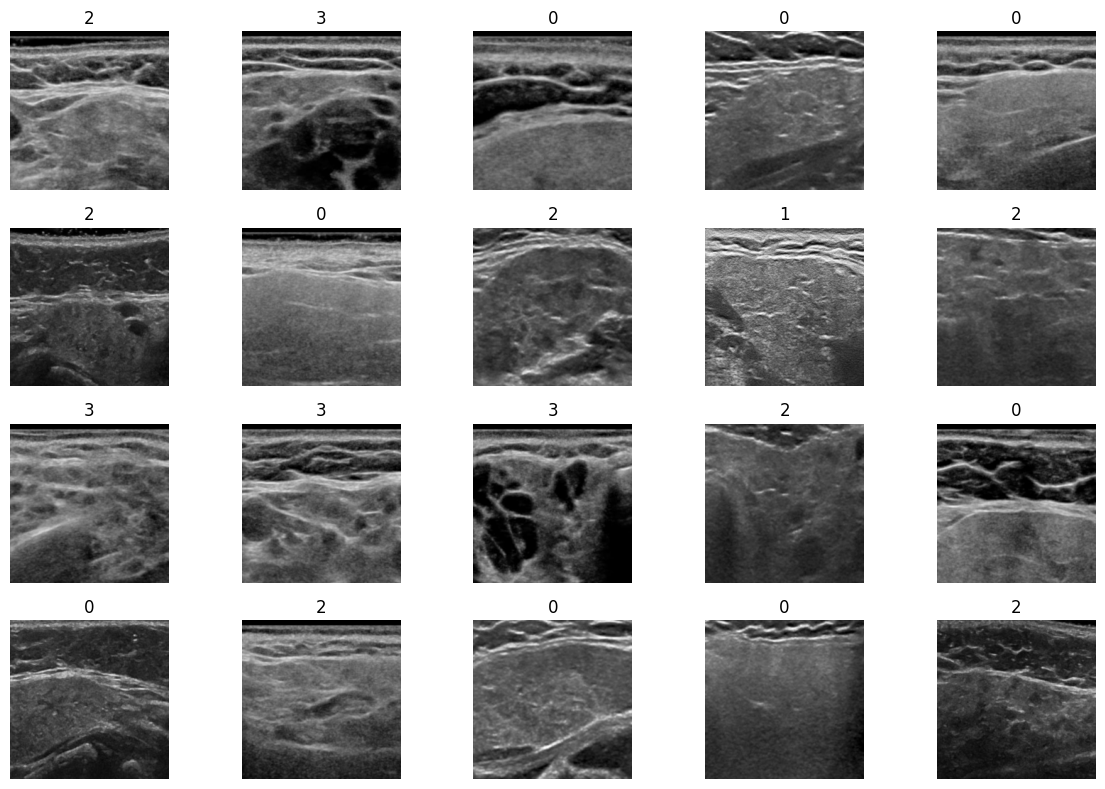

In [9]:
#PLOT ORIGINALS:
import matplotlib.pyplot as plt
import numpy as np

# Define la función para visualizar las imágenes
def plot_images(images, labels, num_images=20):
    # Selecciona aleatoriamente num_images índices de las imágenes
    indices = np.random.choice(len(images), num_images, replace=False)

    # Configura la figura para mostrar las imágenes
    plt.figure(figsize=(12, 8))
    for i, index in enumerate(indices):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[index])
        plt.title(labels[index])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualiza imágenes de entrenamiento
plot_images(train_data, train_labels, num_images=20)

# Visualiza imágenes de validación
plot_images(val_data, val_labels, num_images=20)

# Visualiza imágenes de prueba
plot_images(test_data, test_labels, num_images=20)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from scipy.ndimage import gaussian_filter, map_coordinates
import numpy as np
import matplotlib.pyplot as plt

#Lists to store augmented data
augmented_images_list = []
augmented_labels_list = []

class ElasticDeformationLayer(layers.Layer):
    def __init__(self, alpha=34, sigma=4, **kwargs):
        super(ElasticDeformationLayer, self).__init__(**kwargs)
        self.alpha = alpha
        self.sigma = sigma

    def call(self, image):
        image_shape = image.shape
        if len(image_shape) == 3:
            image = tf.expand_dims(image, 0)

        image = tf.numpy_function(self._elastic_deformation, [image], tf.float32)
        image.set_shape(image_shape)
        return image

    def _elastic_deformation(self, image):
        random_state = np.random.RandomState(None)
        shape = image.shape[1:]
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), self.sigma, mode="constant", cval=0) * self.alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), self.sigma, mode="constant", cval=0) * self.alpha
        dz = np.zeros_like(dx)

        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))

        distorted_image = map_coordinates(image[0], indices, order=1, mode='reflect')
        return distorted_image.reshape(image.shape[1:])


augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    #layers.RandomTranslation(0.2, 0.2),
    #layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.GaussianNoise(0.1),
    ElasticDeformationLayer()
]


def data_augmentation(image):
    for layer in augmentation_layers:
        image = layer(image)
    return image

def show_image_label(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title('Label: {}'.format(label))
    plt.axis('off')


for image, label in zip(train_data, train_labels):

    augmented_image = data_augmentation(image)
    augmented_images_list.append(augmented_image)
    augmented_labels_list.append(label)


augmented_images = np.array(augmented_images_list)
augmented_labels = np.array(augmented_labels_list)

final_train_images = np.concatenate((train_data, augmented_images), axis=0)
final_train_labels = np.concatenate((train_labels, augmented_labels), axis=0)

print("Dimensiones de las imágenes originales:", train_data.shape)
print("Dimensiones de las etiquetas originales:", train_labels.shape)
print("Dimensiones de las imágenes aumentadas:", augmented_images.shape)
print("Dimensiones de las etiquetas aumentadas:", augmented_labels.shape)
print("Dimensiones del conjunto de datos final (imágenes):", final_train_images.shape)
print("Dimensiones del conjunto de datos final (etiquetas):", final_train_labels.shape)


Dimensiones de las imágenes originales: (115, 224, 224, 3)
Dimensiones de las etiquetas originales: (115,)
Dimensiones de las imágenes aumentadas: (115, 224, 224, 3)
Dimensiones de las etiquetas aumentadas: (115,)
Dimensiones del conjunto de datos final (imágenes): (230, 224, 224, 3)
Dimensiones del conjunto de datos final (etiquetas): (230,)


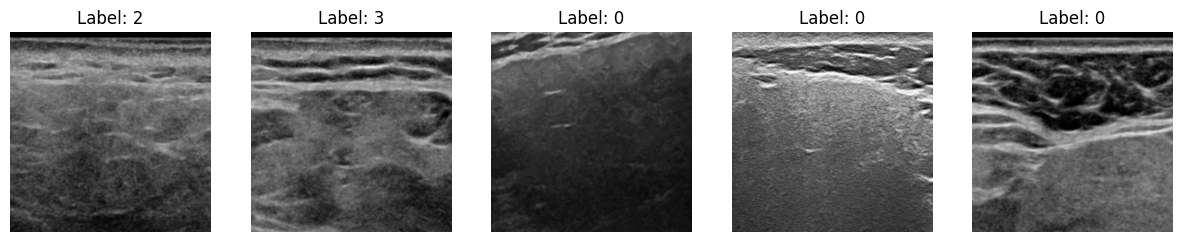

In [11]:
import random
import matplotlib.pyplot as plt

# Función para mostrar imágenes aleatorias
def show_random_images(images, labels, num_images=5):
    # Seleccionar índices aleatorios
    random_indices = random.sample(range(len(images)), num_images)

    # Configurar el tamaño de la figura
    plt.figure(figsize=(15, 3))

    # Mostrar las imágenes y etiquetas seleccionadas
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx], cmap='gray')  # Ajusta el mapa de colores según sea necesario
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

# Visualizar algunas imágenes aumentadas de forma aleatoria
show_random_images(final_train_images, final_train_labels)

# **MODEL:**

Epoch 1/26
15/15 [==============================] - 44s 3s/step - loss: 41.7299 - accuracy: 0.3304 - val_loss: 44.7502 - val_accuracy: 0.2500
Epoch 2/26
15/15 [==============================] - 42s 3s/step - loss: 40.8860 - accuracy: 0.3565 - val_loss: 25.4504 - val_accuracy: 0.6042
Epoch 3/26
15/15 [==============================] - 41s 3s/step - loss: 26.4359 - accuracy: 0.4870 - val_loss: 16.3386 - val_accuracy: 0.5208
Epoch 4/26
15/15 [==============================] - 42s 3s/step - loss: 18.3256 - accuracy: 0.5739 - val_loss: 13.9063 - val_accuracy: 0.5417
Epoch 5/26
15/15 [==============================] - 42s 3s/step - loss: 16.8726 - accuracy: 0.6174 - val_loss: 14.2719 - val_accuracy: 0.5417
Epoch 6/26
15/15 [==============================] - 38s 3s/step - loss: 17.4368 - accuracy: 0.5130 - val_loss: 16.5637 - val_accuracy: 0.5833
Epoch 7/26
15/15 [==============================] - 42s 3s/step - loss: 14.8119 - accuracy: 0.5739 - val_loss: 10.8454 - val_accuracy: 0.5417
Epoch 

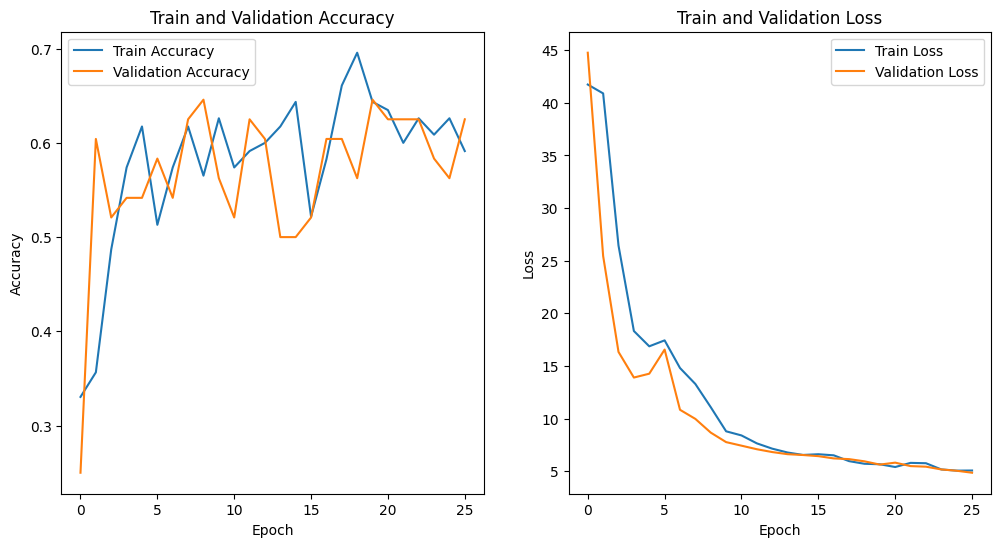

2/2 [==============================] - 7s 1s/step - loss: 4.7023 - accuracy: 0.6486
Test Accuracy: 0.6486486196517944


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Supongamos que tus etiquetas son enteros que van de 0 a num_classes-1
num_classes = 4  # Cambia esto al número real de clases en tus datos

# Convertir las etiquetas a one-hot encoding
train_labels_one_hot = to_categorical(train_labels, num_classes)
val_labels_one_hot = to_categorical(val_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)

# Configurar los parámetros del modelo
input_shape = (224, 224, 3)

# Crear generadores de aumento de datos para entrenamiento y validación
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator()

# Crear generadores de datos a partir de los arrays de NumPy
train_generator = train_datagen.flow(
    train_data,
    train_labels_one_hot,
    batch_size=8
)

val_generator = val_datagen.flow(
    val_data,
    val_labels_one_hot,
    batch_size=8
)

# Cargar el modelo ResNet50V2 pre-entrenado sin incluir las capas densas superiores
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar todas las capas del modelo base (es decir, hacerlas no entrenables)
base_model.trainable = False

# Agregar capas adicionales encima del modelo base
model = Sequential([
    base_model,  # Capas del modelo base
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),  # Agrega Dropout con una tasa de abandono del 50%
    Dense(num_classes, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Descongelar las últimas N capas del modelo base para fine-tuning
fine_tune_from = -8

for layer in base_model.layers[fine_tune_from:]:
    layer.trainable = True

# Entrenar el modelo con los datos preprocesados y aumentados
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=26,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator))

# Imprimir las curvas de entrenamiento y pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Evaluar el modelo en el conjunto de datos de prueba
test_loss, test_accuracy = model.evaluate(test_data, test_labels_one_hot)
print("Test Accuracy:", test_accuracy)
